# ASTR 596: The Final

#### Three questions, each worth a third of your grade. (I'll make one 34 pts to get to an even 100). Each is designed to test an area where I think the class as a whole is less comfortable. They are sorted by my assesment of difficulty from easiest to hardest. 
#### i.e. the last is probably going to be non-trivial, because well I like Gaussian distributions of grades. 
#### That's OK because the points and grades don't matter!

#### Remember, you can work together, discuss problems and solutions, but you have to write up your own solution. I'd strongly suggest doing that, ideally with some divide and conquer strategy.

### Q1. Using unsupervised learning to work with galaxies

The following query will select 20k likely galaxies from the SDSS database and return the results of that query into an `astropy Table`.  (For now, if you are not familiar with the SDSS DB schema, don't worry about this query, just know that it returns a bunch of photometric features.)

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database

GALquery = """SELECT TOP 20000 
         p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
         p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
         p.petroRad_i, p.petroR50_i, p.deVAB_i, p.fracDev_i
         FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
         WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
         AND p.deVAB_i > -999 AND p.petroRad_i > -999 AND p.petroR50_i > -999 AND p.dered_r < 20
           """
SDSSgals = SDSS.query_sql(GALquery)
SDSSgals

ug,gr,gi,gz,petroRad_i,petroR50_i,deVAB_i,fracDev_i
float64,float64,float64,float64,float64,float64,float64,float64
1.999718,0.9592915,1.370582,1.692535,5.454633,2.344662,0.8708095,1.0
1.98884,0.9332962,1.361919,1.668918,5.177937,2.424093,0.9946066,0.8865207
1.020407,1.601521,2.396175,2.827263,5.846272,1.158836,0.6898293,1.0
1.83742,1.211882,1.688545,1.989878,7.145427,2.795447,0.7493948,1.0
4.55904,1.536175,2.29286,2.712597,4.741546,2.09032,0.5173162,0.8244159
4.532835,1.433081,2.251518,2.669952,8.930706,1.656738,0.6116931,1.0
...,...,...,...,...,...,...,...
1.186504,0.7330265,1.118578,1.321369,3.876745,1.874162,0.486329,0.1205378
1.066797,2.601061,3.690748,4.120882,3.379689,1.555406,0.9997188,0.9116547


### 1a - Visualize the dataset in g-i (y) vs u-g (x) and all the features (11 pts). 

The bluest galaxies are star-forming galaxies at low redshift 𝑧. The "tight" cluster of red galaxies are passive galaxies at low-𝑧. Finally the diffuse cloud at 𝑔−𝑖≈3 are high-𝑧 luminous red galaxies (LRGs) that were targeted for BAO measurements. These sources have a wide range of 𝑢−𝑔 colors because they essentially are not detected in the 𝑢 band as this is blueward of the Lyman break.

Plot and examine each of the features in this data set using seaborn's `PairGrid`. Overlay a histogram and kernel density distribution (KDE) on each 1D and 2D plot. You should be able to roughly see the different groups of galaxies, but how to separate them?

In [2]:
import seaborn as sns
import scipy.stats as st
import numpy as np


In [3]:
SDSSgals = SDSSgals.to_pandas()


In [4]:
SDSSgals

,ug,gr,gi,gz,petroRad_i,petroR50_i,deVAB_i,fracDev_i
0,1.999718,0.959291,1.370582,1.692535,5.454633,2.344662,0.870810,1.000000
1,1.988840,0.933296,1.361919,1.668918,5.177937,2.424093,0.994607,0.886521
2,1.020407,1.601521,2.396175,2.827263,5.846272,1.158836,0.689829,1.000000
3,1.837420,1.211882,1.688545,1.989878,7.145427,2.795447,0.749395,1.000000
4,4.559040,1.536175,2.292860,2.712597,4.741546,2.090320,0.517316,0.824416
...,...,...,...,...,...,...,...,...
19995,1.043707,0.369907,0.652544,0.736378,8.330991,3.847564,0.668393,0.321042
19996,1.601667,0.889227,1.326288,1.640806,5.831782,2.656174,0.312131,0.441391
19997,1.894600,0.839129,1.232498,1.545040,3.728850,1.715510,0.489710,0.785160
19998,0.855942,1.549755,2.324318,2.694418,3.175705,1.275622,0.813596,1.000000


In [5]:
cols = ['ug','gr','gi','gz','petroRad_i','petroR50_i','deVAB_i','fracDev_i']

In [6]:
means = []
for idx,i in enumerate(cols):
    means.append(np.mean(SDSSgals[cols[idx]]))

In [7]:
deviations = st.median_abs_deviation(SDSSgals[cols],nan_policy='omit')

In [8]:
SDSSgals = SDSSgals[SDSSgals.ug<(means[0]+20*deviations[0])]
SDSSgals = SDSSgals[SDSSgals.ug>(means[0]-20*deviations[0])]

SDSSgals = SDSSgals[SDSSgals.gr<(means[1]+20*deviations[1])]
SDSSgals = SDSSgals[SDSSgals.gr>(means[1]-20*deviations[1])]

SDSSgals = SDSSgals[SDSSgals.gi<(means[2]+20*deviations[2])]
SDSSgals = SDSSgals[SDSSgals.gi>(means[2]-20*deviations[2])]

SDSSgals = SDSSgals[SDSSgals.gz<(means[3]+20*deviations[3])]
SDSSgals = SDSSgals[SDSSgals.gz>(means[3]-20*deviations[3])]

SDSSgals = SDSSgals[SDSSgals.petroRad_i<(means[4]+20*deviations[4])]
SDSSgals = SDSSgals[SDSSgals.petroRad_i>(means[4]-20*deviations[4])]

SDSSgals = SDSSgals[SDSSgals.petroR50_i<(means[5]+20*deviations[5])]
SDSSgals = SDSSgals[SDSSgals.petroR50_i>(means[5]-20*deviations[5])]

# SDSSgals = SDSSgals[SDSSgals.deVAB_i<(means[6]+20*deviations[6])]
# SDSSgals = SDSSgals[SDSSgals.fracDev_i<(means[7]+20*deviations[7])]


In [9]:
SDSSgals

,ug,gr,gi,gz,petroRad_i,petroR50_i,deVAB_i,fracDev_i
0,1.999718,0.959291,1.370582,1.692535,5.454633,2.344662,0.870810,1.000000
1,1.988840,0.933296,1.361919,1.668918,5.177937,2.424093,0.994607,0.886521
2,1.020407,1.601521,2.396175,2.827263,5.846272,1.158836,0.689829,1.000000
3,1.837420,1.211882,1.688545,1.989878,7.145427,2.795447,0.749395,1.000000
4,4.559040,1.536175,2.292860,2.712597,4.741546,2.090320,0.517316,0.824416
...,...,...,...,...,...,...,...,...
19995,1.043707,0.369907,0.652544,0.736378,8.330991,3.847564,0.668393,0.321042
19996,1.601667,0.889227,1.326288,1.640806,5.831782,2.656174,0.312131,0.441391
19997,1.894600,0.839129,1.232498,1.545040,3.728850,1.715510,0.489710,0.785160
19998,0.855942,1.549755,2.324318,2.694418,3.175705,1.275622,0.813596,1.000000


Text(0, 0.5, 'gi')

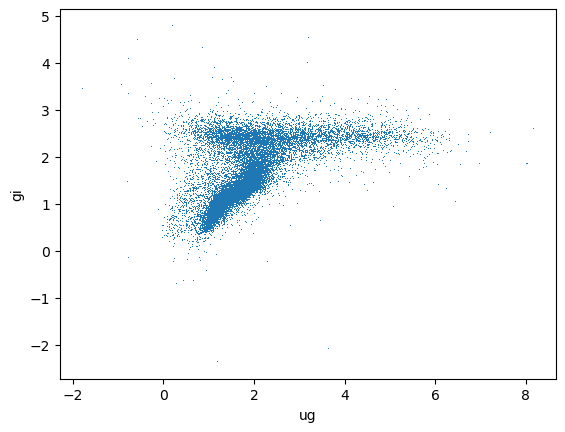

In [19]:
plt.plot(SDSSgals.ug,SDSSgals.gi,',')
plt.xlabel("ug")
plt.ylabel("gi")

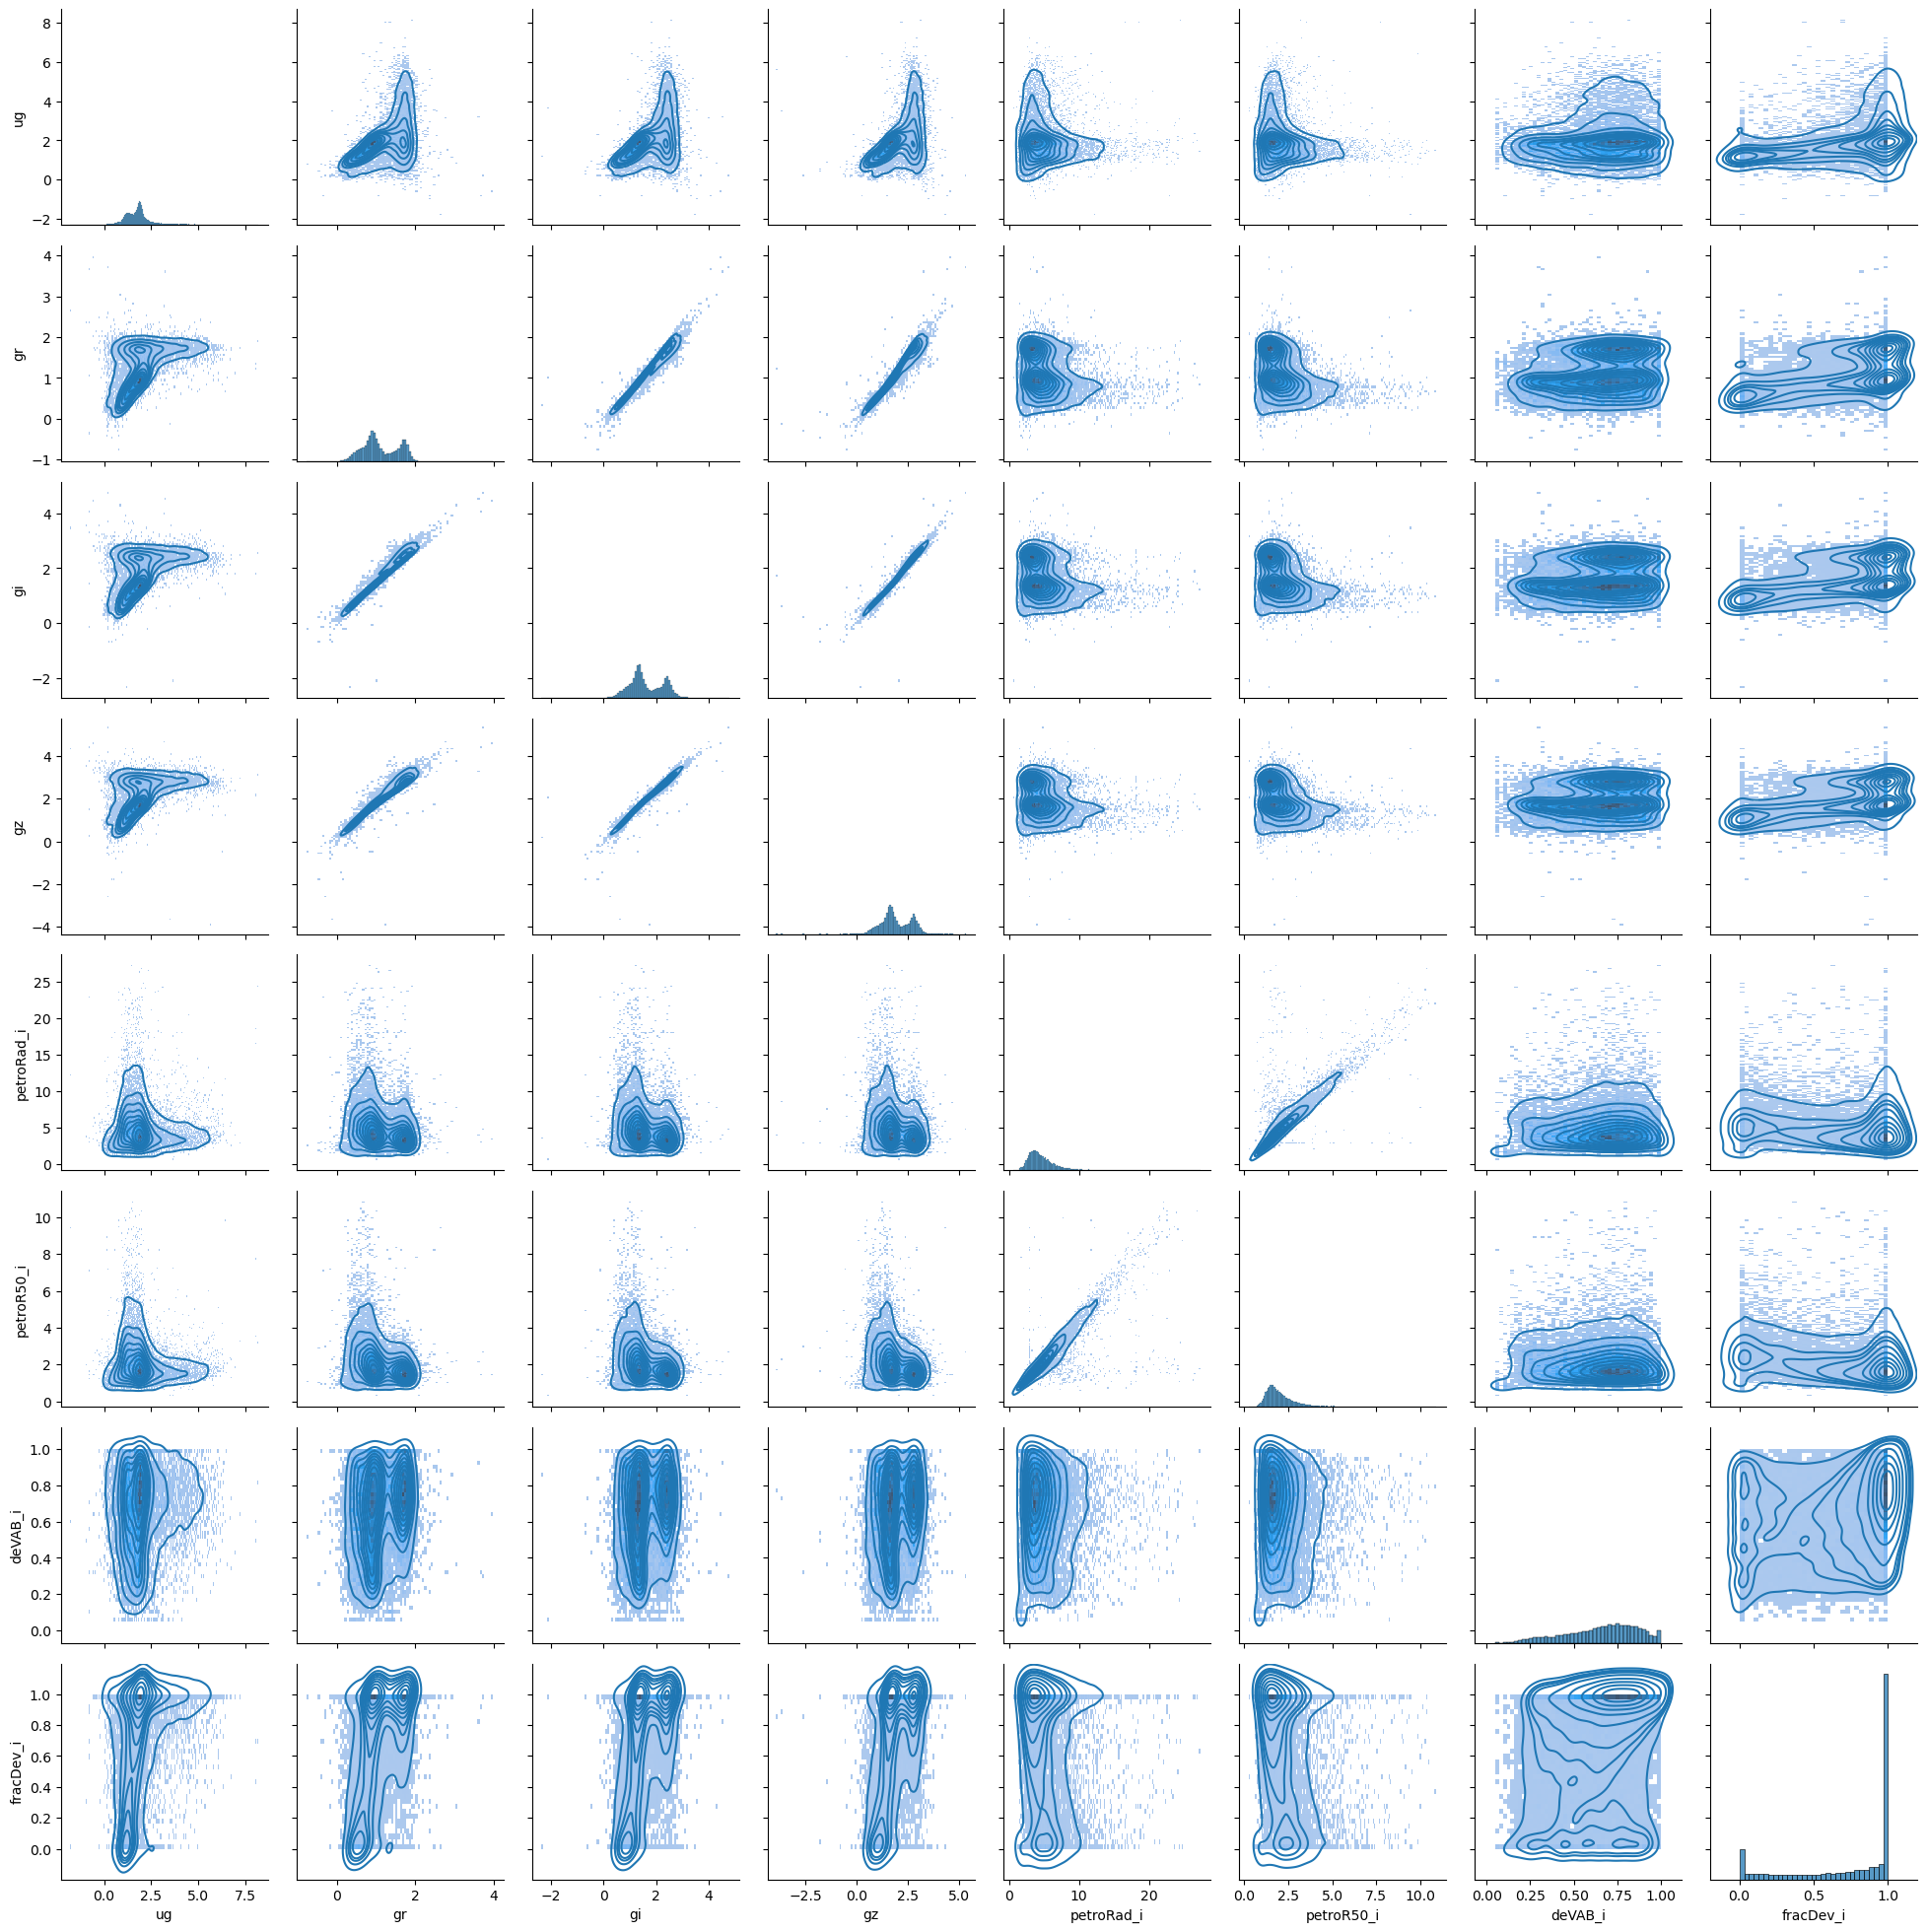

In [10]:
g = sns.PairGrid(SDSSgals)
g.map_diag(sns.histplot)

g.map_offdiag(sns.histplot)
g.map_offdiag(sns.kdeplot)

### 1b - Separating the galaxy types (11 pts) 

Using K-means from `sklearn` with n=3, separate the three clusters of galaxies. Initial guesses, hyper-paramter tuning, dimensionality reduction etc are your choices. What's important is to be able to justify them. To the referee, to me, to yourself. We'll do that in the next part. 

In [22]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler


In [55]:
kmeans = KMeans(n_clusters=3, n_init = 50, max_iter = 1000, tol = 0.000001)
z = StandardScaler()


In [56]:
Xt = z.fit_transform(SDSSgals)


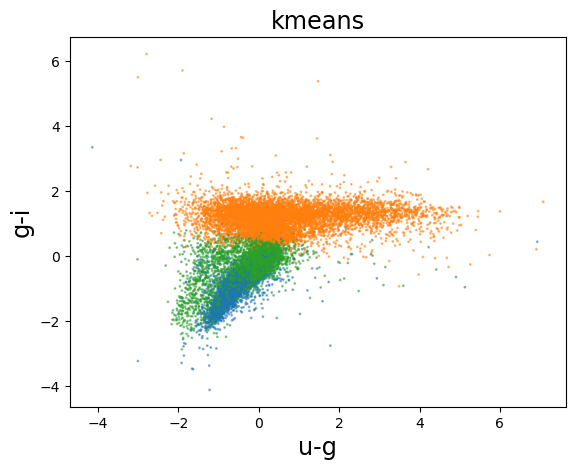

In [57]:
kmeans.fit(Xt)
labels = kmeans.labels_
color = [f'C{i}' for i in labels]
plt.scatter(Xt[:,0], Xt[:,1], color=color, s = 1, alpha = .5)
ax = plt.gca()

ax.set_xlabel('u-g', fontsize='xx-large')
ax.set_ylabel('g-i', fontsize='xx-large')
ax.set_title('kmeans', fontsize='xx-large');

In [61]:
SDSSgals['label'] = labels

### 1c - Working with the distributions (11 pts)
Repeat 1a, but using the results of K-means in 1b to create separately colored distributions for your different classes of galaxies. Use the KDE to provide the mean values of each feature and their standard deviation (hint - these are integrals), and compare them to the sample means and standard deviations. 

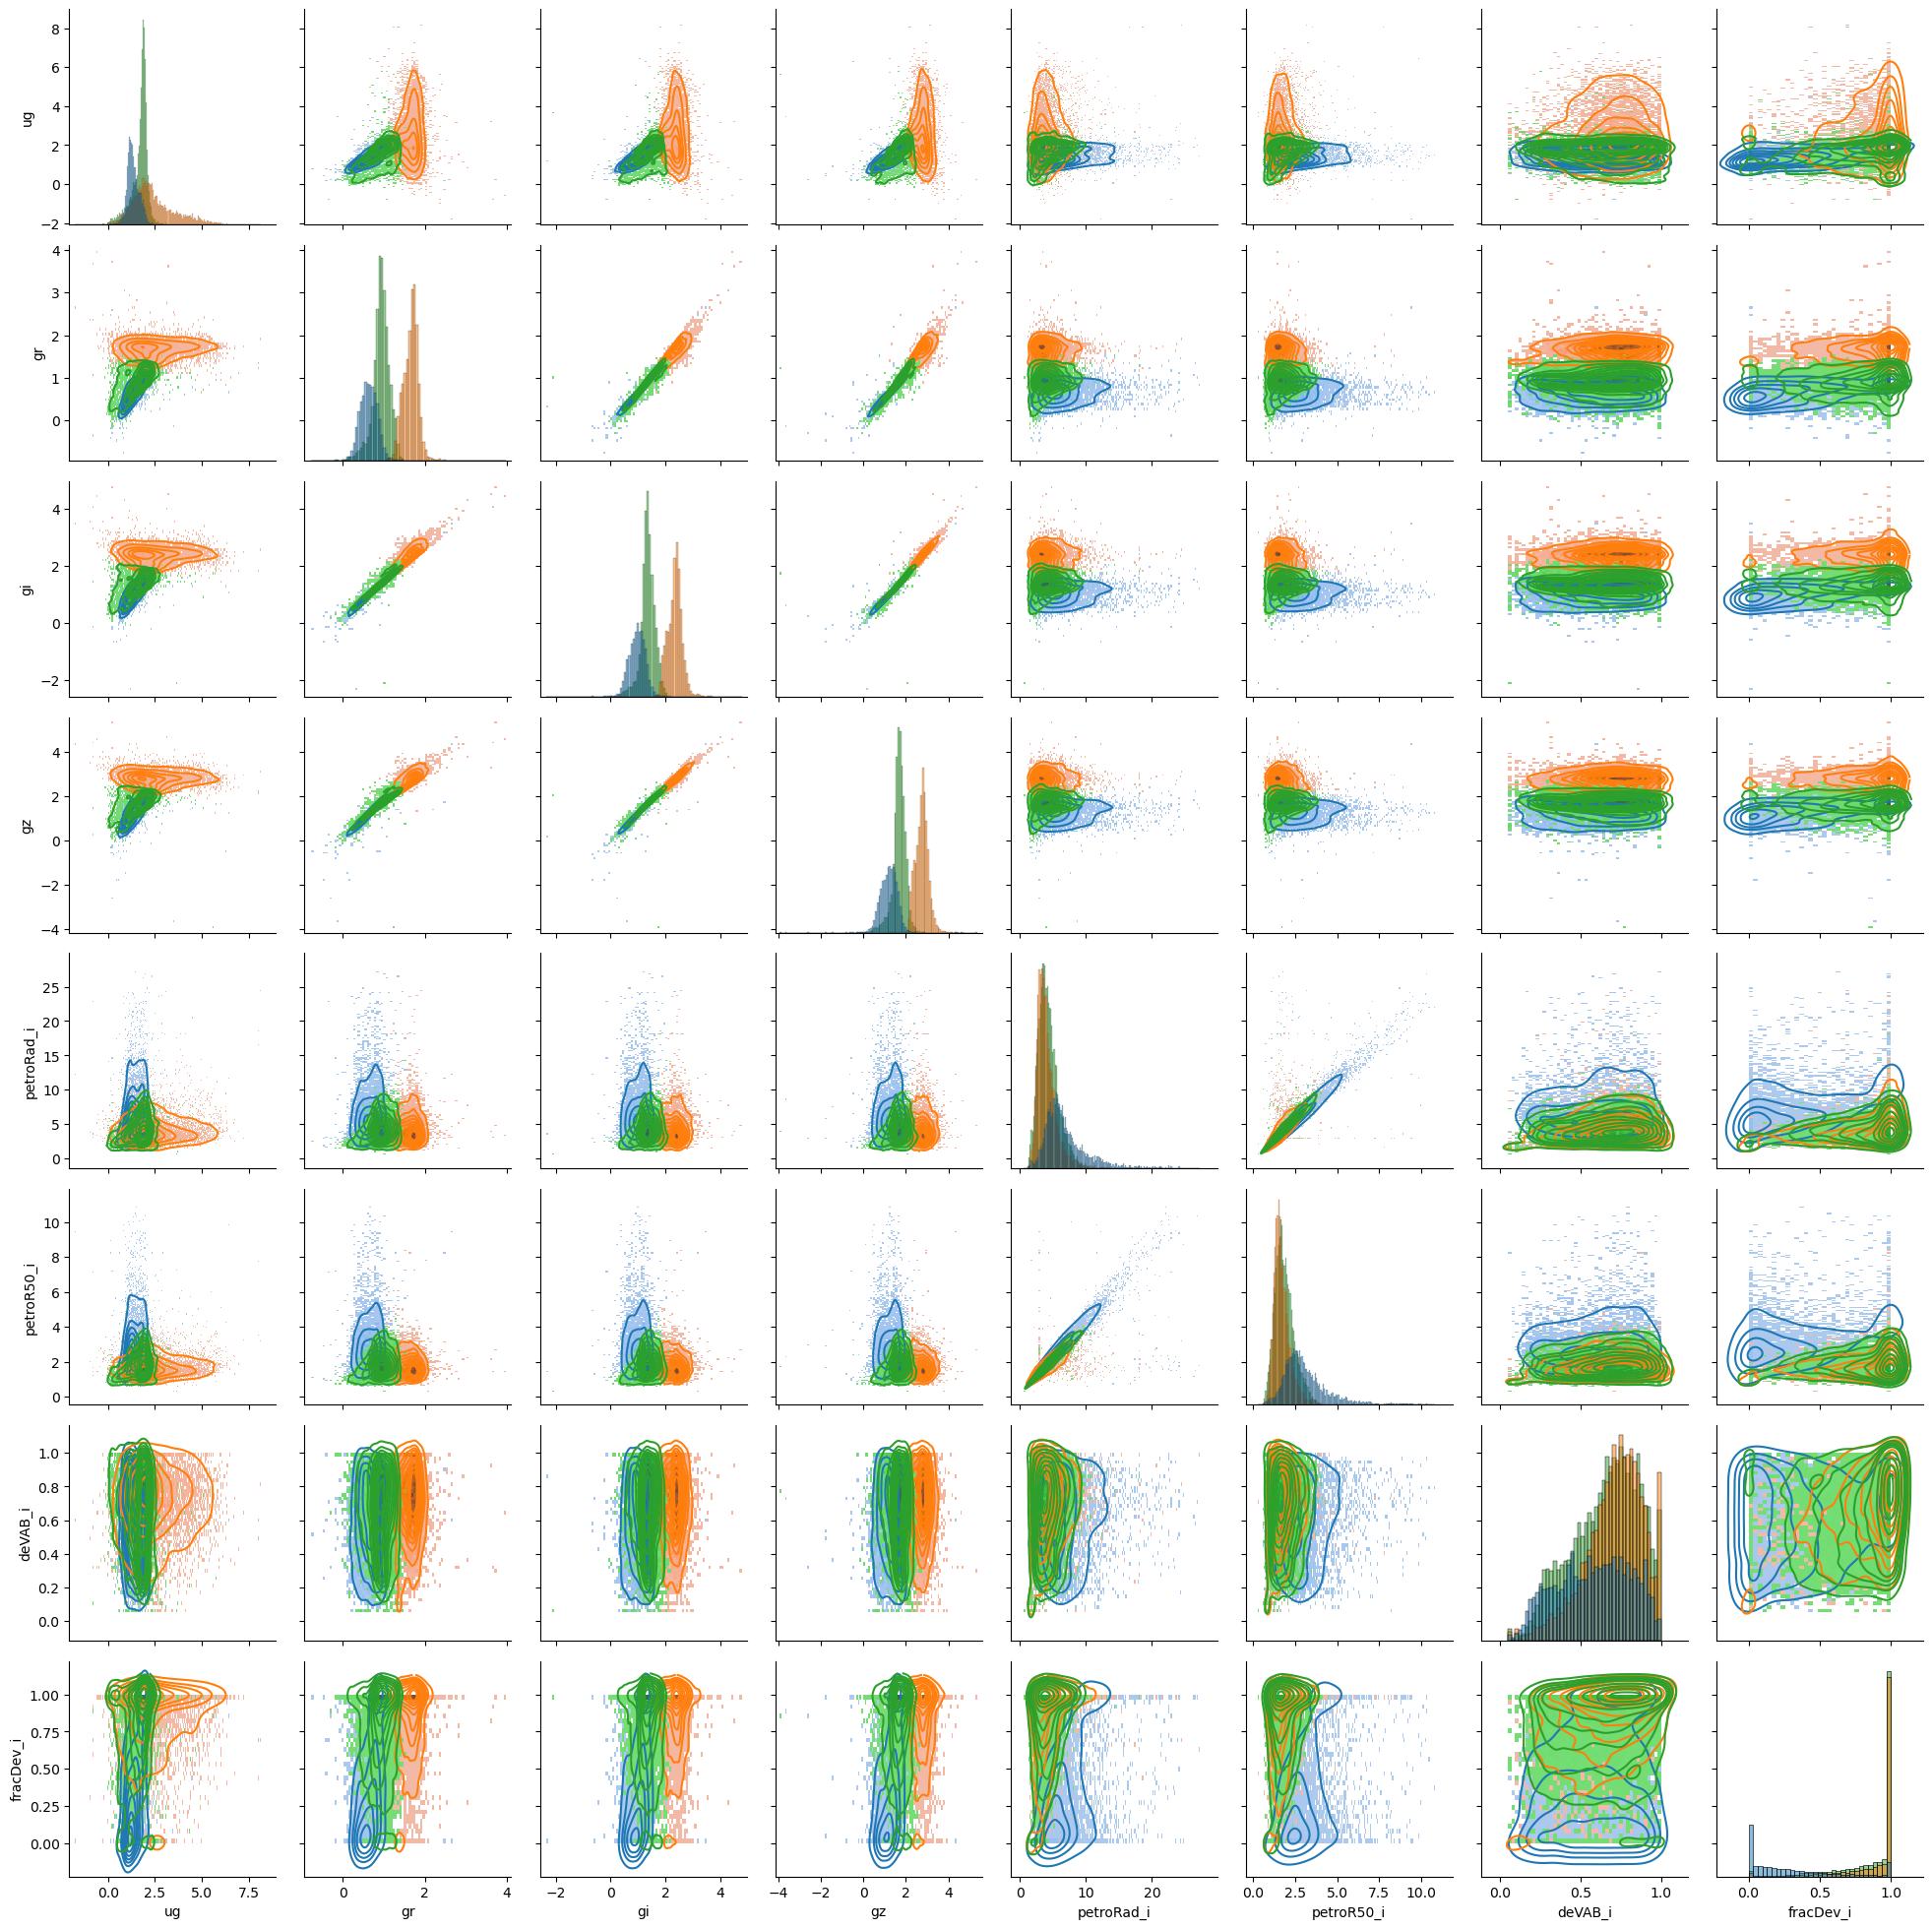

In [65]:
g = sns.PairGrid(SDSSgals, hue="label", palette='tab10',diag_sharey=False)
g.map_diag(sns.histplot)

g.map_offdiag(sns.histplot)
g.map_offdiag(sns.kdeplot)


In [155]:
label_0 = SDSSgals[SDSSgals.label==0]
label_1 = SDSSgals[SDSSgals.label==1]
label_2 = SDSSgals[SDSSgals.label==2]

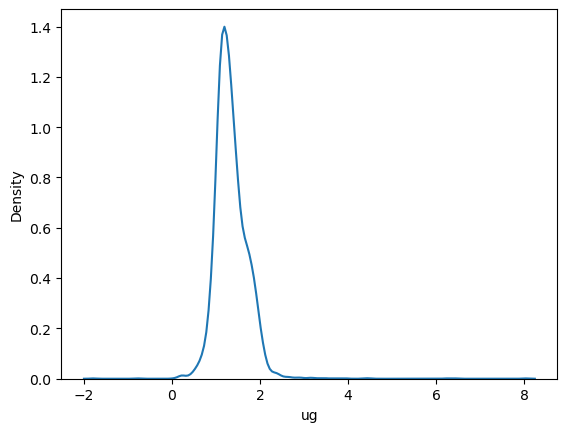

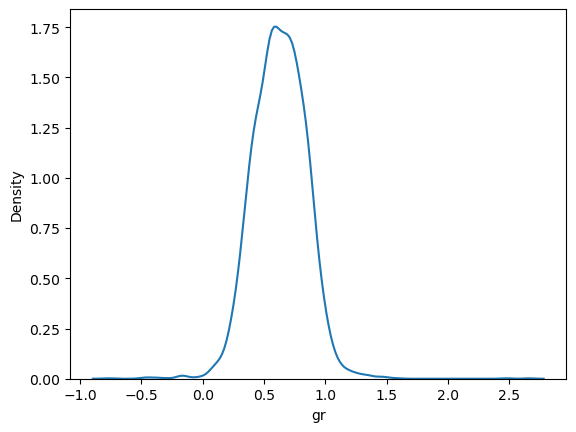

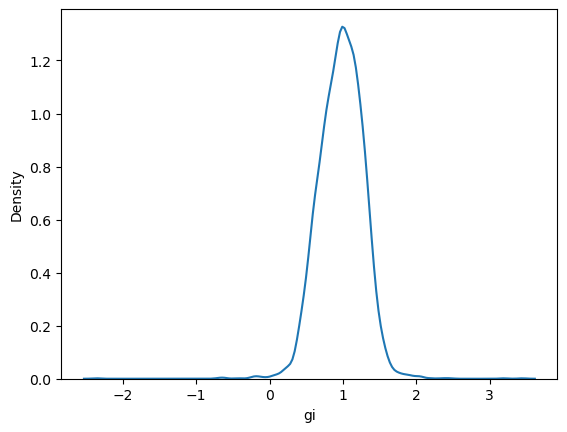

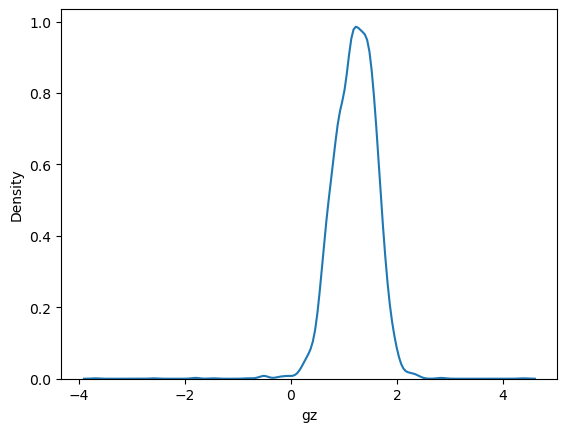

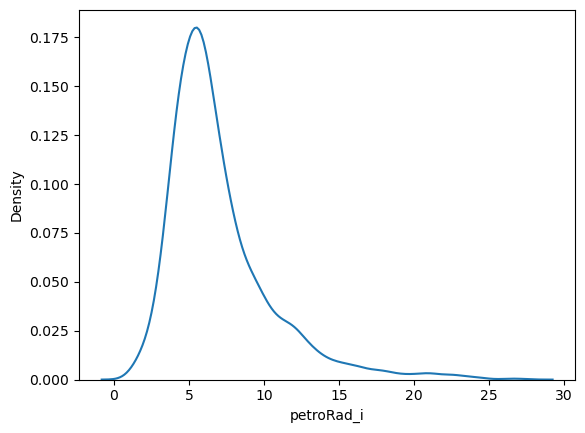

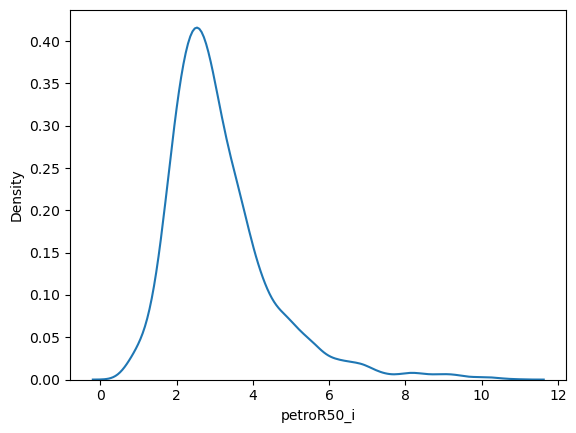

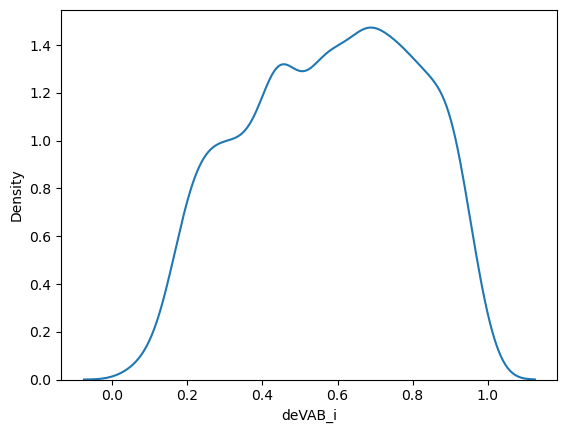

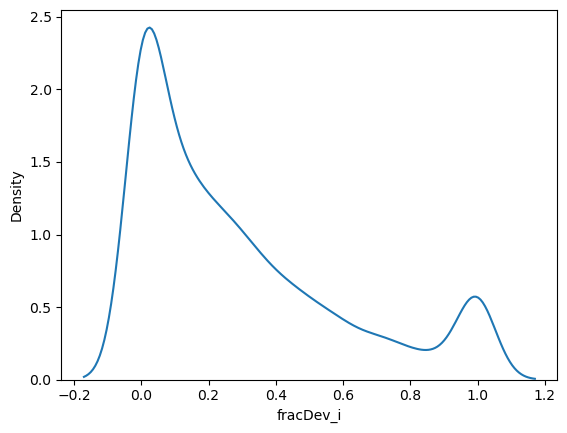

[1.3436354039940628, 0.6271532091273497, 0.9767786687849619, 1.197618646936413, 7.027020812476401, 3.135647622659949, 0.5799269280813517, 0.2868201287672395]
[0.391367438821818, 0.22216202684151273, 0.30719354633493695, 0.40849998965181816, 3.566756323369202, 1.3981368001318386, 0.22896799343443575, 0.3108878899356495]


In [181]:
mus_0 = []
std_0 = []
for ind,i in enumerate(cols):
    ax = sns.kdeplot(label_0[cols[ind]])
    kdeline = ax.lines[0]
    mean = label_0[cols[ind]].mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    mu = np.trapz((xs*ys), xs)
    mus_0.append(mu)
    std_0.append(np.sqrt(np.trapz((xs-mu)**2*ys,xs)))
    plt.show()
print(mus_0)
print(std_0)

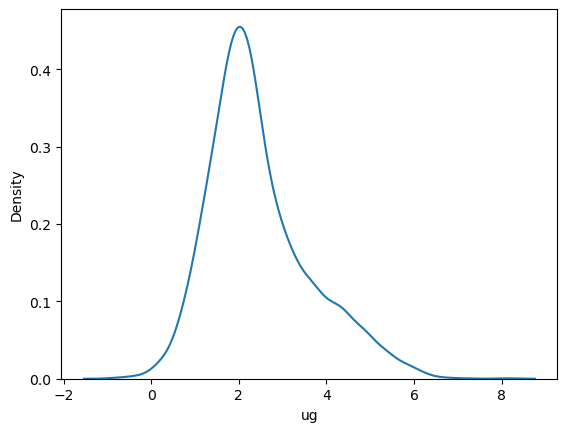

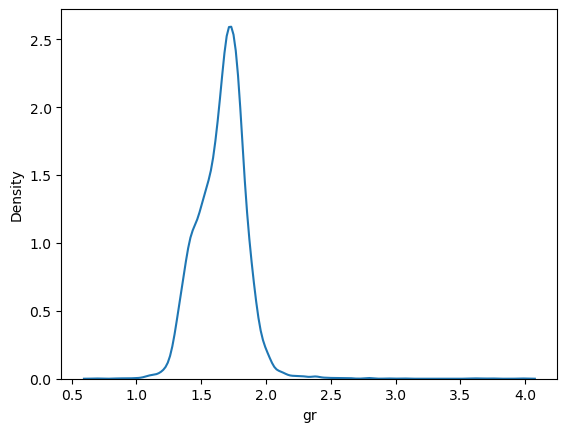

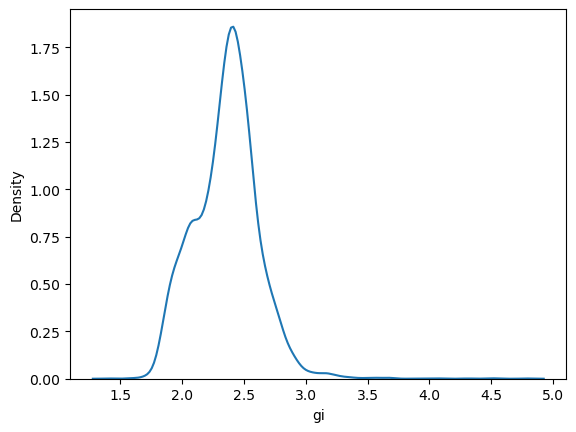

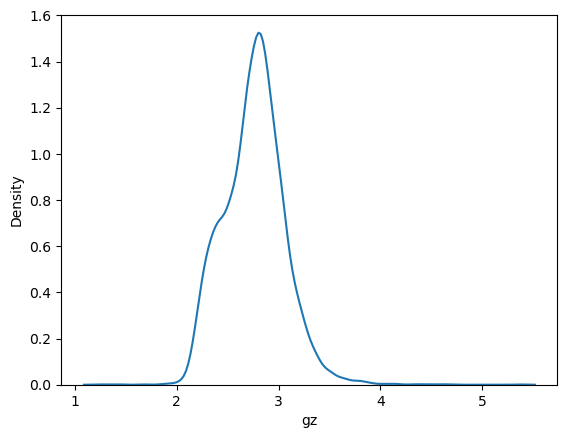

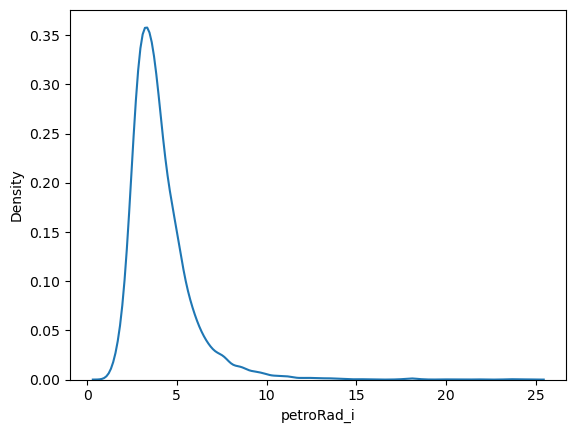

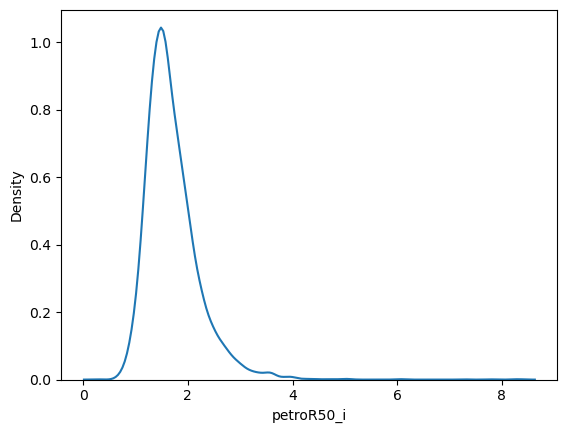

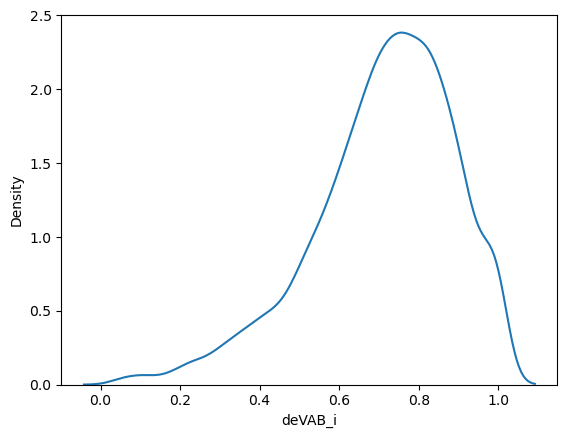

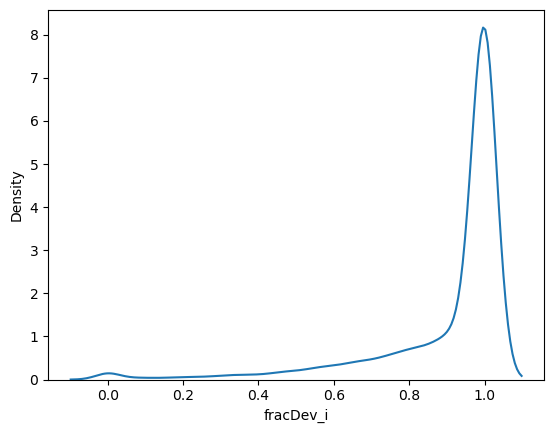

[2.451114203083839, 1.6593052373342918, 2.3570588120477254, 2.757791192616179, 4.105640010616276, 1.703515930464298, 0.7108984161765626, 0.9020099423942731]
[1.1849636201883786, 0.19073925692511604, 0.26614801158240303, 0.3047110681927345, 1.781659152247692, 0.5314157614705578, 0.1816059730371365, 0.19452206203669278]


In [182]:
mus_1 = []
std_1 = []
for ind,i in enumerate(cols):
    ax = sns.kdeplot(label_1[cols[ind]])
    kdeline = ax.lines[0]
    mean = label_1[cols[ind]].mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    mu = np.trapz((xs*ys), xs)
    mus_1.append(mu)
    std_1.append(np.sqrt(np.trapz((xs-mu)**2*ys,xs)))
    plt.show()
print(mus_1)
print(std_1)

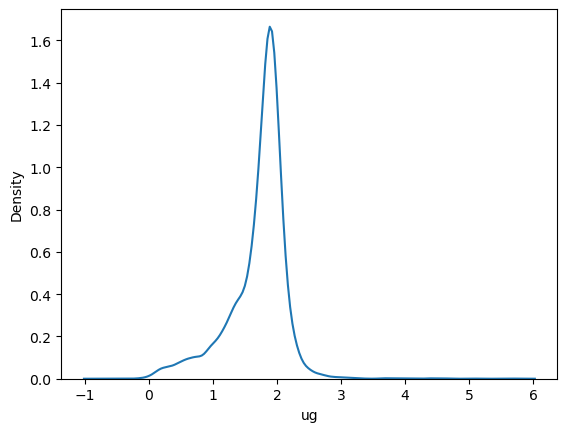

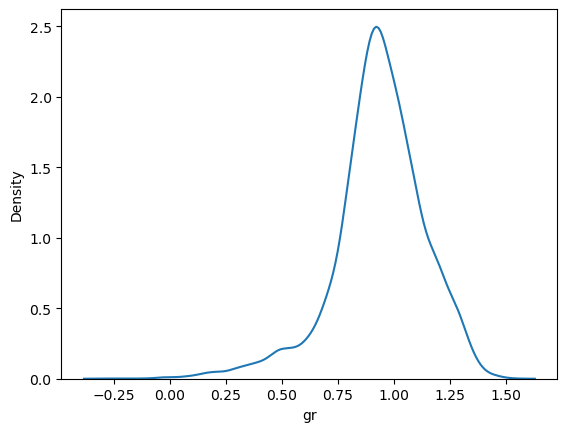

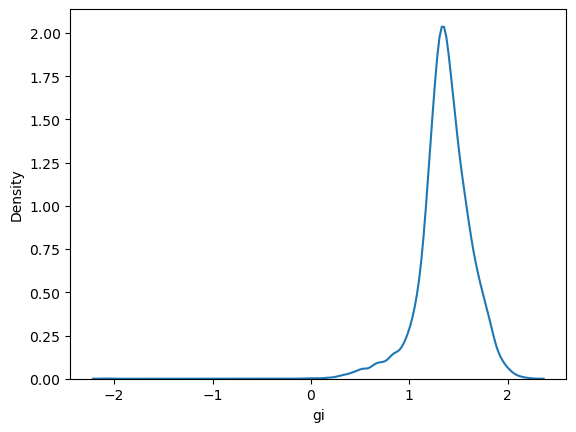

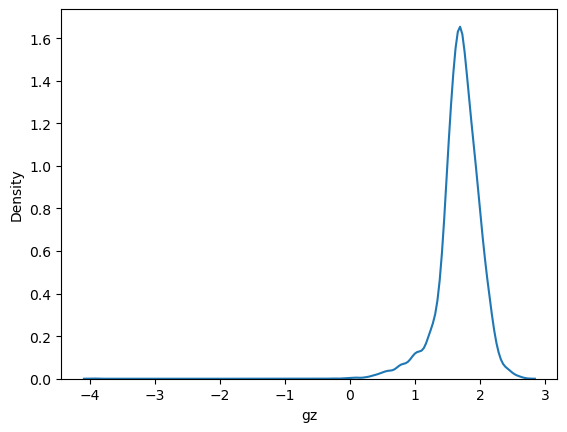

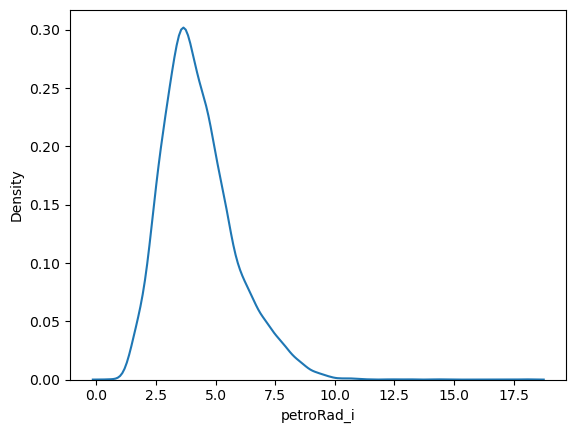

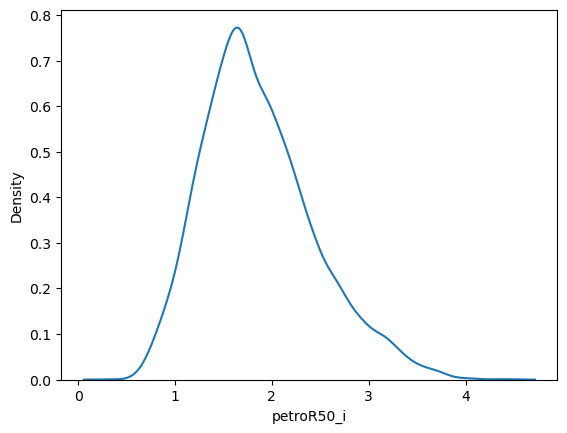

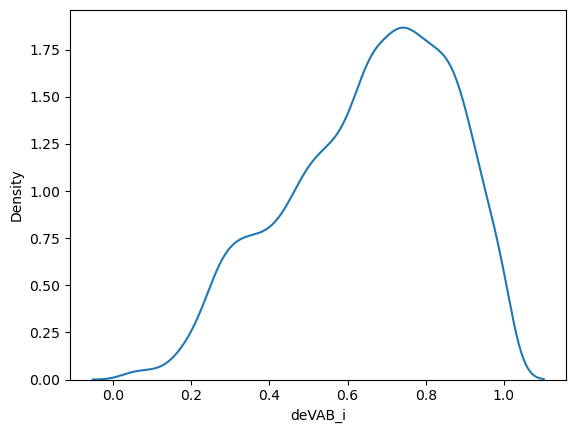

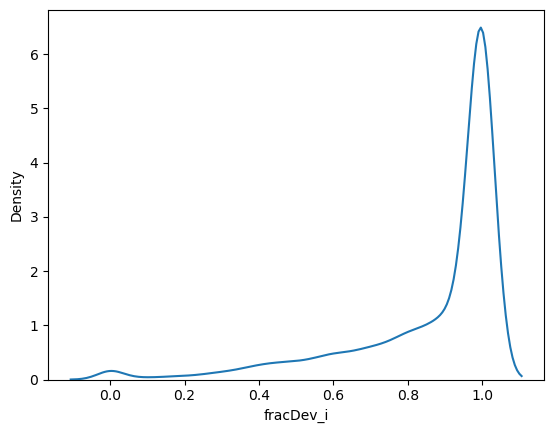

[1.7102866403785748, 0.9342137641465339, 1.3658147912821554, 1.6828862082588798, 4.2903604891626, 1.8629839539303445, 0.6567944763668383, 0.8648125517454435]
[0.45692954323899604, 0.20798964048705884, 0.26580698274976183, 0.32398341706685735, 1.5438953978664995, 0.5869994338172052, 0.21008376527198125, 0.21887380056426256]


In [183]:
mus_2 = []
std_2 = []
for ind,i in enumerate(cols):
    ax = sns.kdeplot(label_2[cols[ind]])
    kdeline = ax.lines[0]
    mean = label_2[cols[ind]].mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    mu = np.trapz((xs*ys), xs)
    mus_2.append(mu)
    std_2.append(np.sqrt(np.trapz((xs-mu)**2*ys,xs)))
    plt.show()
print(mus_2)
print(std_2)

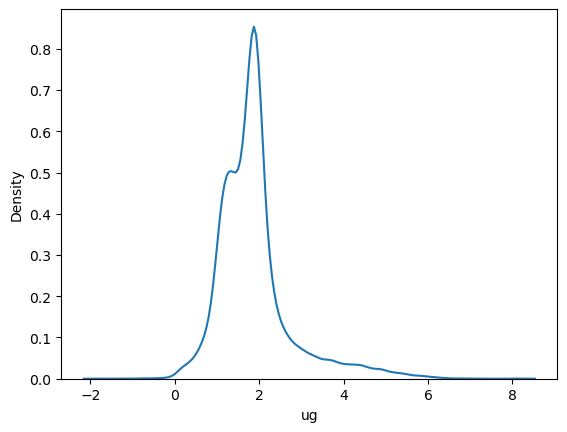

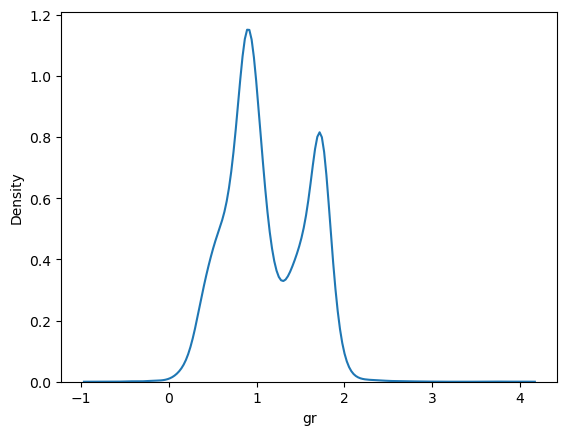

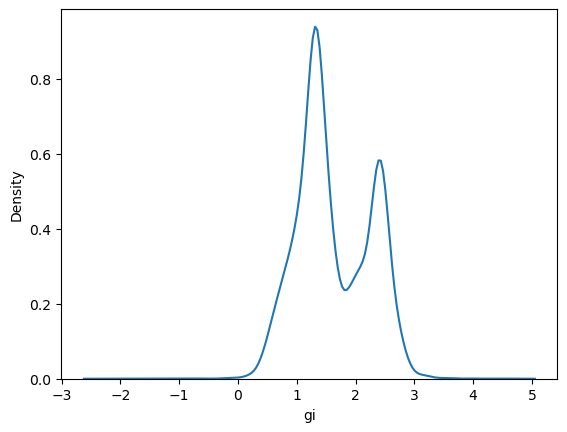

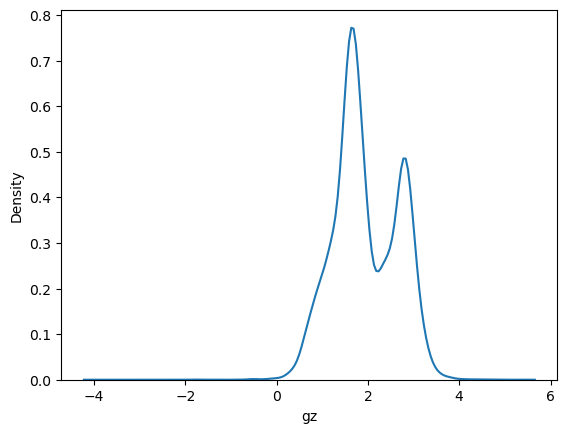

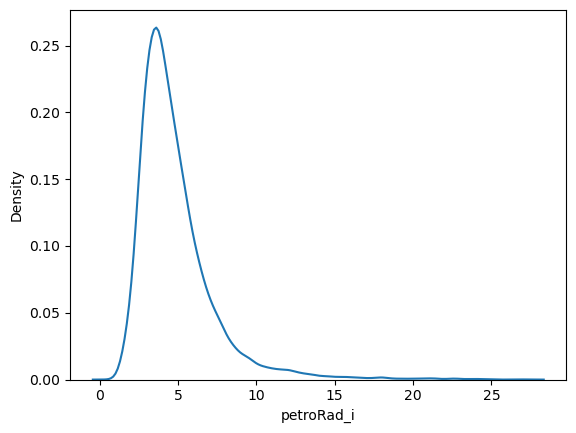

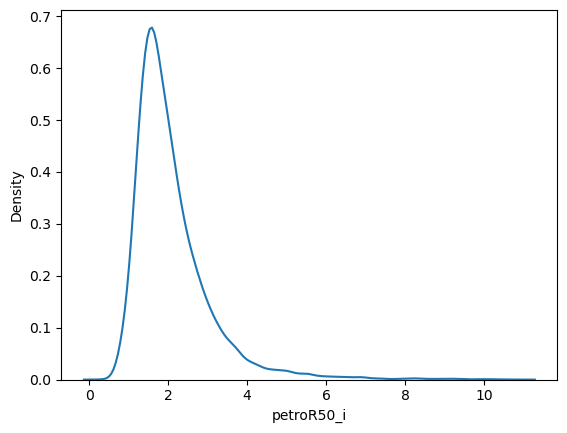

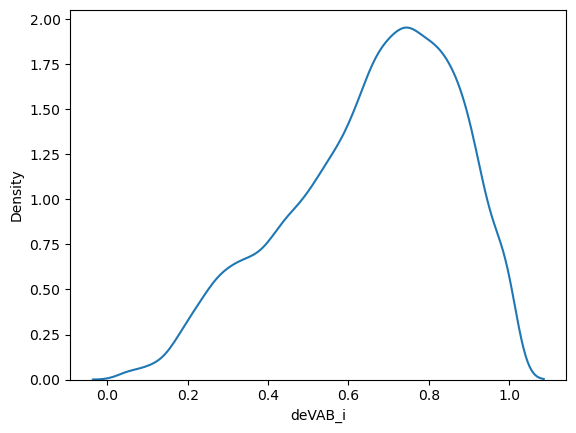

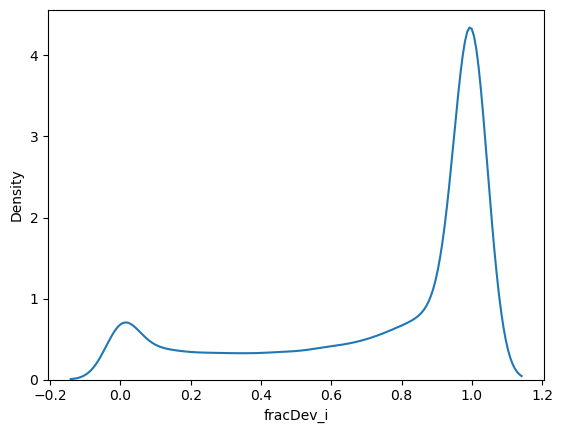

[1.8850909745242528, 1.1170670885173921, 1.62276498821545, 1.9471277033721441, 4.8474244698826325, 2.0964164746969822, 0.6581882721359967, 0.7464999461774503]
[0.8952037755021488, 0.46497013100757534, 0.6259764985587998, 0.7120919041880649, 2.5246571150442856, 1.0040619880870754, 0.2100155235457564, 0.3442015918872198]


In [184]:
mus_tot = []
std_tot = []
for ind,i in enumerate(cols):
    ax = sns.kdeplot(SDSSgals[cols[ind]])
    kdeline = ax.lines[0]
    mean = SDSSgals[cols[ind]].mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    mu = np.trapz((xs*ys), xs)
    mus_tot.append(mu)
    std_tot.append(np.sqrt(np.trapz((xs-mu)**2*ys,xs)))
    plt.show()
print(mus_tot)
print(std_tot)

In [194]:
d = {'sample mean': mus_tot, 'label 0 mean' : mus_0, 'label 1 mean': mus_1,'label 2 mean' : mus_2,'sample deviation': std_tot, 'label 0 deviation' : std_0,'label 1 deviation': std_1,'label 2 deviation' : std_2}
df = pd.DataFrame(data=d,index=cols)


In [195]:
df

,sample mean,label 0 mean,label 1 mean,label 2 mean,sample deviation,label 0 deviation,label 1 deviation,label 2 deviation
ug,1.885091,1.343635,2.451114,1.710287,0.895204,0.391367,1.184964,0.456930
gr,1.117067,0.627153,1.659305,0.934214,0.464970,0.222162,0.190739,0.207990
gi,1.622765,0.976779,2.357059,1.365815,0.625976,0.307194,0.266148,0.265807
gz,1.947128,1.197619,2.757791,1.682886,0.712092,0.408500,0.304711,0.323983
petroRad_i,4.847424,7.027021,4.105640,4.290360,2.524657,3.566756,1.781659,1.543895
petroR50_i,2.096416,3.135648,1.703516,1.862984,1.004062,1.398137,0.531416,0.586999
deVAB_i,0.658188,0.579927,0.710898,0.656794,0.210016,0.228968,0.181606,0.210084
fracDev_i,0.746500,0.286820,0.902010,0.864813,0.344202,0.310888,0.194522,0.218874


Or could just do it an easier way.....

In [119]:
mean_0 = []
deviations_0 = []
for idx,i in enumerate(cols):
    mean_0.append(np.mean(label_0[cols[idx]]))
for idx, i in enumerate(cols):
    deviations_0.append(np.std(label_0[i]))
mean_1 = []
deviations_1 = []
for idx,i in enumerate(cols):
    mean_1.append(np.mean(label_1[cols[idx]]))
    deviations_1.append(np.std(label_1[i]))
mean_2 = []
deviations_2 = []
for idx,i in enumerate(cols):
    mean_2.append(np.mean(label_2[cols[idx]]))
    deviations_2.append(np.std(label_2[i]))


In [120]:
mean_tot = []
deviations_tot = []
for idx,i in enumerate(cols):
    mean_tot.append(np.mean(SDSSgals[cols[idx]]))
    deviations_tot.append(st.median_abs_deviation(SDSSgals[i]))

In [190]:
d = {'sample mean': mean_tot, 'sample deviation': deviations_tot, 'label 0 mean' : mean_0, 'label 0 deviation' : deviations_0, 'label 1 mean': mean_1,'label 1 deviation': deviations_1,'label 2 mean' : mean_2,'label 2 deviation' : deviations_2}
df = pd.DataFrame(data=d,index=cols)


In [191]:
df

,sample mean,sample deviation,label 0 mean,label 0 deviation,label 1 mean,label 1 deviation,label 2 mean,label 2 deviation
ug,1.885091,0.371086,1.343638,0.384814,2.451116,1.168104,1.710288,0.450917
gr,1.117067,0.342281,0.627154,0.218430,1.659306,0.188029,0.934214,0.205251
gi,1.622765,0.435765,0.976779,0.302037,2.357060,0.262363,1.365815,0.262311
gz,1.947128,0.501566,1.197619,0.401644,2.757793,0.300378,1.682886,0.319728
petroRad_i,4.847427,1.110104,7.027029,3.506786,4.105646,1.756332,4.290364,1.523575
petroR50_i,2.096417,0.437365,3.135651,1.374626,1.703518,0.523863,1.862985,0.579270
deVAB_i,0.658221,0.144823,0.579937,0.225124,0.710950,0.179044,0.656828,0.207336
fracDev_i,0.747213,0.046384,0.286875,0.305897,0.902973,0.191884,0.865610,0.216131


### Q2. Gaussian Processes + Emcee

There are many sources with periodic light curves that are not strictly sinusoidal. Thus, the use of the cosine kernel (on its own) may not be sufficient to model the signal. The quasi-periodic kernel: 

$$K_{ij} = k(x_i - x_j) = A \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

is useful for non-sinusoidal signals. It is implemented in the `george` package. Note that the parameters in the kernel aren't the only parameters you might need... look back on your previous homework assignments and think about what I'm glossing over here. 

I've given you an example light curve file with a decidedly non-sinusoidal, periodic signal from the ASAS-SN project from our colleagues at OSU. 

### 2a - Implement the model  (11 pts)

Examine this data, filter it as you see fit (I've included the file header in full - I'd pick one aperture, and look at the grades and notes about separate datasets). You can make tradeoffs here - more data that is potentially messier, vs less data so weaker constraints, but cleaner. Pick something that you can justify (and if you're struggling at 2c, examine this choice before twiddling with emcee). 

Write down a model for it with the likelihood function, an appropriate prior and posterior.

You may wish to look at the `george` documentation again, particularly how some parameters are better log transformed if the expectation is that they are positive real values. 

https://george.readthedocs.io/en/latest/tutorials/model/

### 2b - Initial Guesses (11 pts)

Make some initial guess for the parameters. For the period, use Lomb-Scargle to find the top three periods for this light curve. Initialize 1/3rd of the walkers to each of the top three periods

Do the burn in with `emcee` - a 100 walkers and a 1000 steps should be plenty - you should find that the walkers have migrated away from the starting guess. Plot the chains. 

Make a plot of the log of the Posterior vs the log of the Period - select the periods with the highest log Posterior and change the initial guess for the Period of all the walkers to be in a small region around the Period with the highest log Posterior. 

### 2c - Infer the model parameters (11 pts)

Plot the chains, the corner plot, the folded lightcurve, the Gaussian process model given the median parameters, 10 other draws from the model and the uncertainty about the model. 


N.B. you should be a bit worried about "burn in" and how the walkers were initialized throughout. If you plan to use GPs to search for periods in your own work, I highly recommend you read Angus et al. 2018 on the GP periodogram. Angus et al. provide far more intelligent methods for initializing the MCMC than what is presented here. 

### Q3: PyMC (yes, that thing), hierarchical mixture models, and the mass-radius relation for small exoplanets

The mass-radius relation is a relationship between the radius $R$ of an exoplanet and its mass $M$. We usually call planets smaller than the Neptune size $(R < 4 R_{\oplus})$ small planets. In the Solar System, we don't have any planets between the Earth and Neptune sizes ($ 1-4 R_{\oplus}$), whereas in extrasolar systems, plenty of planets with radii in the range are observed. Thus, it's extremely intriguing to study the compositions of these planets and understand why we don't have one in the Solar System.

In this problem, you will work on one of the papers that one of our colloquium speakers brought up (this is why you should go to colloquium btw, because it'd have totally helped with this final exam to know the answer) - the mass-radius relation for small exoplanets around M-dwarfs. 

The paper is by [Luque et al., Science 377, 1211 (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220903871L/abstract). We will reproduce some of their results using the PyMC.

In [11]:
## Download the dataset from Luque et al. 2022
data = pd.read_csv("https://carmenes.caha.es/ext/tmp/TMP.csv")
data.head()

,ID,ID_Star,Star,AltName,Karmn,RA_J2000,DE_J2000,SpT,SpTnum,d_pc,...,eurho_gcm-3,edrho_gcm-3,Teq_K,euTeq_K,edTeq_K,TSM,ESM,Method,DiscoveryRef,ParameterRef
0,1,1,GJ 3053,LHS 1140,J00449-152,00:44:59.33,-15:16:17.5,M4.5 V,4.5,14.964,...,0.84,0.80,378.9,4.3,4.2,8.88,0.19,RV,Dit17,Dit17 Men19 Lil20
1,2,1,GJ 3053,LHS 1140,J00449-152,00:44:59.33,-15:16:17.5,M4.5 V,4.5,14.964,...,0.81,0.74,708.9,8.0,7.8,25.90,3.45,RV,Dit17,Dit17 Men19 Lil20
2,3,2,TOI-1468,LSPM J0106+1913,J01066+192,01:06:36.98,+19:13:33.2,M3 V,3.0,24.721,...,1.05,0.92,682.2,7.4,6.9,9.00,6.30,RV,Cha22,Cha22
3,4,2,TOI-1468,LSPM J0106+1913,J01066+192,01:06:36.98,+19:13:33.2,M3 V,3.0,24.721,...,0.21,0.19,337.5,3.7,3.4,59.00,NaN,RV,Cha22,Cha22
4,5,3,GJ 3090,TOI-177,NaN,01:21:45.39,-46:42:51.8,M2 V,2.0,22.454,...,0.52,0.45,693.0,18.0,18.0,221.00,NaN,RV,Alm22a,Alm22a


In [12]:
## Lets extract mass and radius and their uncertainties from the data; both M and R are in Earth units 
M = data.M_Mterra
R = data.R_Rterra

err_M = (data.edM_Mterra+data.euM_Mterra)/2  # Assume the + and - errors on M and R are symmetric because lazy
err_R = (data.edR_Rterra+data.euR_Rterra)/2

ind = err_R < 1.
M = M[ind]
R = R[ind]
err_M = err_M[ind]
err_R = err_R[ind]

c=data['rho_gcm-3'][ind]

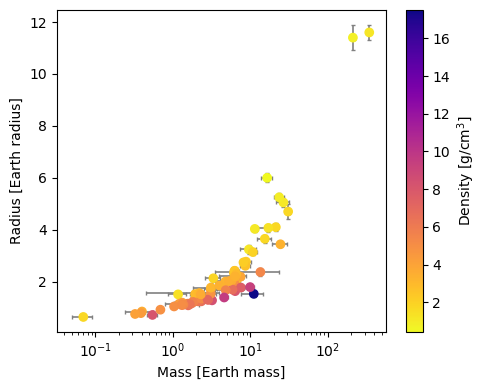

In [13]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(5,4))
plt.errorbar(M, R, xerr=err_M, yerr=err_R,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M, R, c=c, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Exoplaneteers made up cute names to describe planets in different compositions.
- "Rocky world" if a planet has a bulk density similar to the Earth.
- "Water world" if a planet has a bulk density consistent with 50% rocky and 50% water ice.
- "Puffy world" if a planet has a bulk density smaller than the "Water World" density.

Now, while it's possible that this final is making you wish you were on a "puff" of something or the other, we'll restrict our analysis to the rocky and water worlds. It's where the grant dollars are. 


### 3a - modeling the mass radius relation for rocky worlds (11 pts) 

First, select the rocky worlds. 

Let's write down the mass-radius relation for rocky worlds as a power law.

$R = aM^b$, where $a$ is proportional to $1/\rho_{\oplus}$, and $b$ is unitless. If the relation follows $M = \frac{4}{3}\pi R^3 \rho$, we have $a = 1$ and $b = 1/3$. However, in reality, the interior density of planets is not uniform and depends on the equation of state.

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

Hints:
- As a, b have to be positive, I'd suggest Uniform priors on log a, log b, and then using pm.Deterministic to exponentiate them 
- For the masses, since you've selected the rocky worlds, I'd suggest a normal distribution with the sample mean and sample standard deviation of the rocky worlds. 
- Given M, a, b you can use pm.Deterministic to get R_model
- Assume our favorite normal likelihood for R_model. You have the observed radius and their uncertainties from the file.

### 3b - The Mass-Radius Relation for Rocky+Water Worlds (23 pts) 

Let's now add water worlds and model the mass-radius relation for both rocky and water worlds. Physically, it will require two models to describe the mass-radius relations for rocky and water worlds. The tricky part is we don't know exactly which kind of worlds a planet is belong to. In this situation, it is helpful to introduce a categorical variable `z` that is either 0 or 1, with the relative posterior probabilities telling us how Rocky/Watery a planet is.

Select the Rocky Water worlds - see the categories above 3a again. 

To make this work like magic with PyMC and it's Monte-Carlo sampler, we can choose a special prior for our categorial variable: the Drichlet Prior - https://en.wikipedia.org/wiki/Dirichlet_distribution

    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(RockyWaterWorlds))
    

The rest of the PyMC model should be the same as 3a except you are fitting two relations - one for rocky worlds and one for water worlds, so you need two different `a` and `b` parameters - `shape=2` as above should take it. You might want to sort the `a` parameter with `transform=pm.distributions.transforms.ordered` when you define the prior to sort things. 

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

### Throughout, make sure your plots have things like appropriate axes scales, axes labels, errorsbars, legends, reasonable colors. Remember, these are how you tell the story of what you've done, and ultimately what we're looking at.  


### Get started. You know how to do all of this. If not, there's something in a class notebook that can help. I'm on Teams, so direct questions there. 

# Best of luck. You've got this. 